In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [3]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [5]:
print(df["conversion"].value_counts())
print('---')
print(df["offer"].value_counts())

0    54606
1     9394
Name: conversion, dtype: int64
---
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [6]:
df = df.rename(columns={"conversion": "target", "offer": "treatment"})
df['treatment'] = df.treatment.apply(lambda x: 
                                     0 if x == 'No Offer' 
                                     else 1 if x == 'Discount' 
                                     else 1 if  x == 'Buy One Get One' 
                                     else x)
print(df["treatment"].value_counts())

1    42694
0    21306
Name: treatment, dtype: int64


In [7]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                      df['target'], random_state=0)

### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [9]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

К полям:
- history применим standardScaler
- recency, zip_code, channel применим OHE-кодирование
- used_discount, used_bogo, is_referral, treatment оставим без изменения

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [11]:
continuos_cols = ['history']
cat_cols = ['recency', 'zip_code', 'channel']
base_cols = ['used_discount', 'used_bogo', 'is_referral', 'treatment']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [12]:
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.69404171,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.59531277,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 4.14209661,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 0.6889335 ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.34740632,  1.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.08164011,  0.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [14]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [42]:
models_results = {
    'approach': [],
    'uplift@30%': []
}
treat_train = X_train['treatment']
treat_test = X_test['treatment']

cat_features = cat_cols

uplift@30%: 0.0731


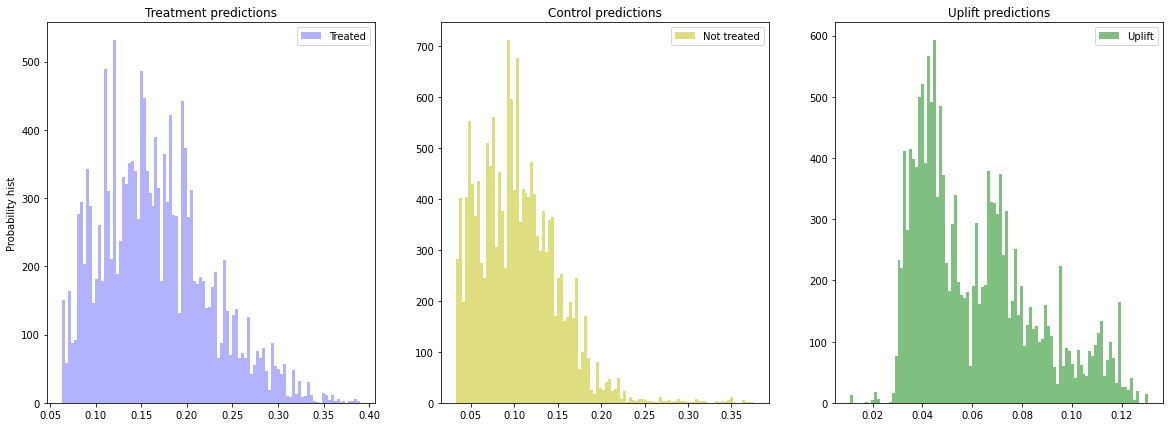

In [43]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);